## Project 1
Marc Hernandez, Tilboon Elberier

In [218]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [219]:

# Importing all packages and functions needed for the assignment

import numpy as np
import matplotlib.pyplot as plt
from pickle import dump
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import sklearn
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
from sklearn import metrics

In [220]:
# Setting the random seed variables for repeatability of results
np.random.seed(42)
random.seed(42)

In [221]:
# Importing the dataset required for 
df = pd.read_csv("Project1-ClassificationDataset.csv")
df.head()

,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
0,'Personalize Your NBA App Experience for the '...,'Personalize Your NBA App Experience for the '...,"['original', 'content', 'live', 'slate', 'game...",NaN,['Official Release'],https://www.nba.com/news/nba-app-new-features-...,basketball,sports
1,'Mike Will attends the Pre-GRAMMY Gala and GRA...,'Mike WiLL Made-It has secured a partnership w...,"['lead', 'espn', 'nbas', 'madeit', 'nba', 'lat...",2023-10-18 16:22:29+00:00,['Marc Griffin'],https://www.vibe.com/news/entertainment/mike-w...,basketball,sports
2,'The Golden State Warriors are struggling to f...,'The Golden State Warriors are struggling to f...,"['insider', 'york', 'thing', 'nbc', 'tag', 'nb...",NaN,[],https://www.nbcnewyork.com/tag/featured-nba/,basketball,sports
3,"'On Nov. 28, the NBA and Nike will collaborate...","'On Nov. 28, the NBA and Nike will collaborate...","['watch', 'telecast', 'ultimate', 'membership'...",NaN,['Official Release'],https://www.nba.com/news/watch-nba-games-ultim...,basketball,sports
4,'The NBA announced additions and innovations t...,'The NBA announced additions and innovations t...,"['experience', 'bring', 'media', 'crennan', 'n...",2023-10-17 12:00:17+00:00,"['Chris Novak', 'About Chris Novak']",https://awfulannouncing.com/tech/nba-app-2023-...,basketball,sports


### QUESTION 1: Provide answers to the following questions:
- Overview: How many rows (samples) and columns (features) are present in the dataset? 

- Histograms: Plot 3 histograms on :

    (a) The total number of alpha-numeric characters per data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis;

    (b) The column leaf label – class on the x-axis; 

    (c) The column root label – class on the x-axis.

- Interpret Plots: Provide qualitative interpretations of the histograms.

The total number of rows in the dataframe 3476
The total number of columns (features) 8


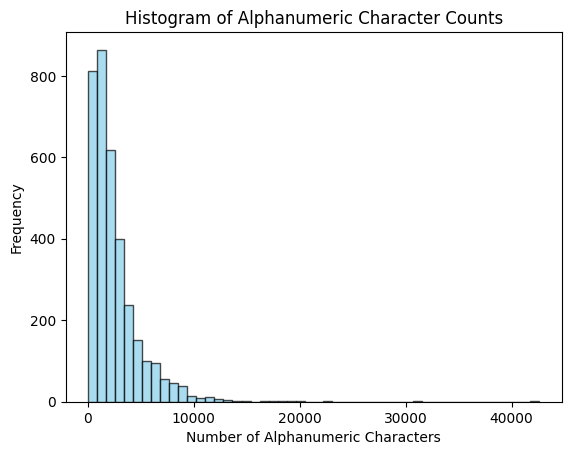

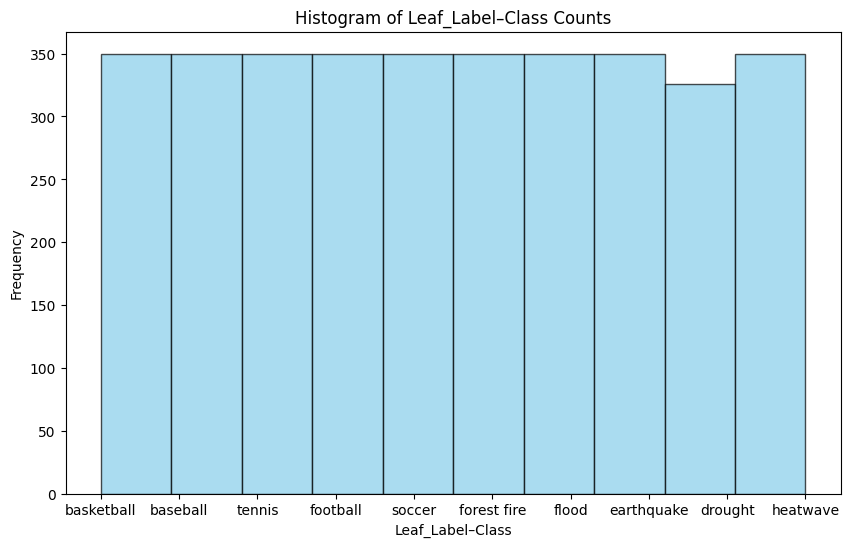

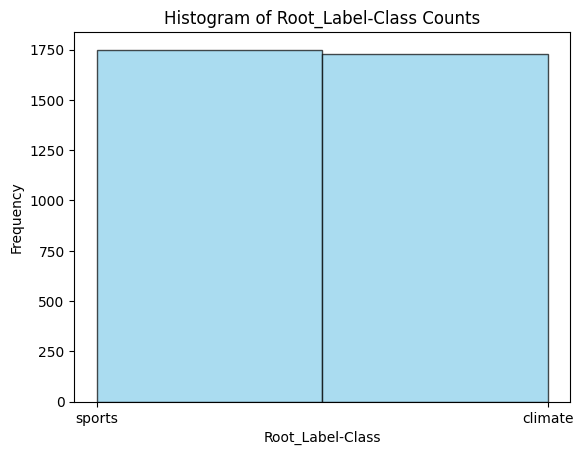

In [222]:
# Code for question 1
print("The total number of rows in the dataframe",df.shape[0])
print("The total number of columns (features)", df.shape[1])

# Histogram a.
df['count'] = df['full_text'].apply(lambda x: sum(char.isalnum() for char in x))
df['count'].plot.hist(bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Alphanumeric Character Counts')
plt.xlabel('Number of Alphanumeric Characters')
plt.ylabel('Frequency')
plt.show()

# Histogram b.
plt.figure(figsize=(10, 6))
plt.hist(df['leaf_label'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Leaf_Label–Class Counts')
plt.xlabel('Leaf_Label–Class')
plt.ylabel('Frequency')
plt.show()

# Histogram c.
plt.hist(df['root_label'], bins=2, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Root_Label-Class Counts')
plt.xlabel('Root_Label-Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keep the x-axis labels horizontal
plt.show()

The previous histograms have provided us with the following information, part (a) demonstrates that the majority of the *full_text* feature contains entries that are within 40000 alpha-numeric characters, with a majority of the entries being less than 10000 characters. Furthermore, in the graphs (b) and (c) we can observe an even distribution of each category across all known types in our hierarchy, which enables future analysis of the data to properly weigh the features against one another due to their frequencies being nearly identical.

### QUESTION 2: Report the number of training and testing samples.

In [223]:
# Code for question 2
train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2)

print("The total number of smaples in the training set is", train.shape[0])
print("The total number of smaples in the testing set is", test.shape[0])

The total number of smaples in the training set is 2780
The total number of smaples in the testing set is 696


### QUESTION 3: Use the following specs to extract features from the textual data:
- Before doing anything, please clean each data sample using the code block provided above.
This function helps remove many but not all HTML artefacts from the crawler’s output. You
can also build your own cleaning module if you find this function to be ineffective.
- Use the “english” stopwords of the CountVectorizer
- Exclude terms that are numbers (e.g. “123”, “-45”, “6.7” etc.)
- Perform lemmatization with nltk.wordnet.WordNetLemmatizer and pos tag
- Use min df=3

Please answer the following questions:
- What are the pros and cons of lemmatization versus stemming? How do these processes affect
the dictionary size?
- min df means minimum document frequency. How does varying min df change the TF-IDF
matrix?
- Should I remove stopwords before or after lemmatizing? Should I remove punctuations before
or after lemmatizing? Should I remove numbers before or after lemmatizing? Hint: Recall
that the full sentence is input into the Lemmatizer and the lemmatizer is tagging the position
of every word based on the sentence structure.
- Report the shape of the TF-IDF-processed train and test matrices. The number of rows should
match the results of Question 2. The number of columns should roughly be in the order of
k ×103. This dimension will vary depending on your exact method of cleaning and lemmatizing
and that is okay.

In [224]:
# Function for cleaning the entries in the full_text feature
import re
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    texter = re.sub(r'[^a-zA-Z\s]', '', texter) # added to get rid of symbols and numbers other than letter
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

In [225]:
# Spec 1: Cleaning the full_text feature in the training and testing set
train['full_text'] = train['full_text'].map(clean)
test['full_text'] = test['full_text'].map(clean)

In [226]:
# Spec 2 & 5: Use the english stopwards of the CountVectorizer, Use min_df=3
min_df = 3
count_vect = CountVectorizer(min_df=min_df, stop_words='english')

In [227]:
# nltk.download()#, if you need "corpora/wordnet", choose it
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
wnl = nltk.wordnet.WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'
    
# Lemmatize and remove terms that are numbers
def lemmatize(data):
    lemmatized_output = []
    for element in data:
        lemmatized_sentence = ' '.join([
            wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in nltk.pos_tag(nltk.word_tokenize(element))
            if not re.match(r'^\d+(\.\d+)?$', word)
        ])
        lemmatized_output.append(lemmatized_sentence)

    return lemmatized_output

[nltk_data] Downloading package punkt to /Users/tilboon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tilboon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/tilboon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/tilboon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/tilboon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [228]:
# Spec 3-4: Lemmatize the full_text feature in the training and testing set (remove #'s)
train_lemmatized = lemmatize(train['full_text'])
test_lemmatized = lemmatize(test['full_text'])

In [229]:
# Vectorization of lemmitized data
X_train_counts = count_vect.fit_transform(train_lemmatized)
X_test_counts = count_vect.transform(test_lemmatized)

In [230]:
# TF-IDF transformation
tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

print("TD-TFIDF-processed Train Matrix Shape: ", X_train_tfidf.shape)
print("TD-TFIDF-processed Test Matrix Shape: ", X_test_tfidf.shape)

TD-TFIDF-processed Train Matrix Shape:  (2780, 13813)
TD-TFIDF-processed Test Matrix Shape:  (696, 13813)


- Bullet 1, Question 3
  - A pro of lemmatization over stemming is that stemmed words may not match the context of the sentance that they were found in, as it relies on a simple rules to find the root word, while lemmatixation attempts to find the root word using linguistics.
  - A con of lemmatization when compared to stemming is its additonal layer of computational complexity, and its requirement of parts-of-speech which is used to better understand the context of the words being processed.
  - In general:
    - Lemmatization pros: considers context producing results that allign with the languages grammar better.
    - Lemmatization cons: more computationally expensive, slower.
    - Stemming pros: faster (simple rules), better for when precise word meaning is not a big deal.
    - Stemming cons: results may not fully align with root form, reduces ictionary size more aggressively and can merge unrelated terms.
- Bullet 2, Question 3
  - *min_df* specifies the minimum number of documents a word must appear in to be included in the vocabulary.
  - As we increase the value of *min_df*, we observe that the total number of collected words begins to decline as less frequently occuring words may be less valuable to our model than other words occuring frequently throughout the text.
  - the number of columns in the tf-idf matrix is reduced also (as we increase min_df)
- Bullet 3, Question 3
  - In general: Punctuation and numbers can be removed prior to lemmatizing as they do not have a large influence on sentance structure and meaning of words, however, stop words should be removed after lemmatizing, as they can play an intergral role in identifying the context of our words of interest.
  - In our case: since we are using pos tagging, stopwords, punctuation, and numbers should be removed after lematization as to not effect the pos tagging process.
- Bullet 4, Question 3
  - As expected with a value of *min_df* = 3, we have a matching number of rows to the result observed in question 2.

### QUESTION 4: Reduce the dimensionality of the data using the methods above:

In [231]:
# Code for Question 4 (LSI)

def LSI_expl_vars(ks):
    expl_vars = []

    for k in ks:
        svd = TruncatedSVD(n_components=k, random_state=42)
        X_train_reduced = svd.fit_transform(X_train_tfidf)
        expl_vars.append(np.sum(svd.explained_variance_ratio_))

    return expl_vars

**Question** Plot the explained variance ratio across multiple different k = [1, 5, 10, 25, 50, 100, 500, 1000]
for LSI and for the next few sections choose k = 25. What does the explained variance ratio
plot look like? What does the plot’s concavity suggest?

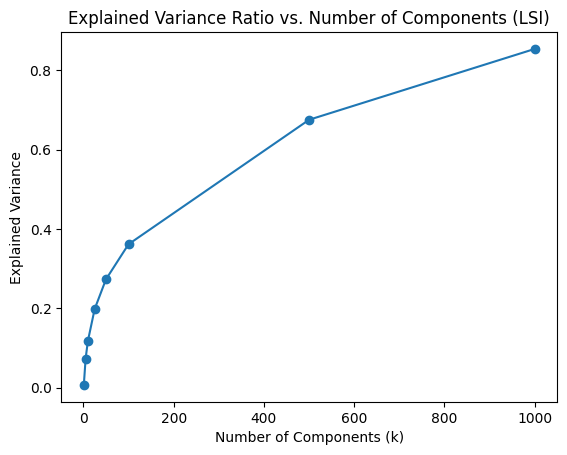

In [232]:
# Plots for Question 4.1

ks = [1,5,10,25,50,100,500,1000]

LSI_expl_vars = LSI_expl_vars(ks)

plt.plot(ks, LSI_expl_vars, marker='o')
plt.title('Explained Variance Ratio vs. Number of Components (LSI)')
plt.xlabel('Number of Components (k)')
plt.ylabel('Explained Variance')
plt.show()

**Answer** The plot shown above shows the explained variance ratio across multiple different k = [1, 5, 10, 25, 50, 100, 500, 1000] for LSI. The explained variance ratio plot looks like a log function plot. The concavity shows that as the number of components (k) increases, the explained variance ratio increases, converging to 1. This shows that the majority of the original data is captured by lower numbers of components (rate of explained variance increase is very rapid early on, and decreases quickly before converging to 1).

**Question** With k = 25 found in the previous sections, calculate the reconstruction residual MSE error
when using LSI and NMF – they both should use the same k = 25. Which one is larger, the $||X − WH||_{F}^2$ in NMF or the $||X − U_k Σ_k V_{k}^T||_{F}^2$ in LSI and why?

In [233]:
# Code for Question 4.2 (NMF)

def custom_NMF(k):
    model = NMF(n_components=k, init='random', random_state=42)
    X_train_NMF = model.fit_transform(X_train_tfidf)
    X_test_NMF = model.transform(X_test_tfidf)
    H = model.components_
    return np.sum(np.array(X_train_tfidf - X_train_NMF.dot(H))**2)

In [234]:
# Code for Question 4.2 (LSI)

def custom_LSI(k):
    svd = TruncatedSVD(n_components=k, random_state=42)
    X_train_LSI = svd.fit_transform(X_train_tfidf)
    X_test_LSI = svd.transform(X_test_tfidf)
    X_approx = svd.inverse_transform(X_train_LSI)
    return X_train_LSI, X_test_LSI, np.sum(np.array(X_train_tfidf - X_approx)**2)

In [249]:
# Question 4.2

k = 25

NMF_reconstruction_residual_error = custom_NMF(k)
X_train_LSI, X_test_LSI, LSI_reconstruction_residual_error = custom_LSI(k)

print("NMF Reconstruction Residual Error: ", NMF_reconstruction_residual_error)
print("LSI Reconstruction Residual Error: ", LSI_reconstruction_residual_error)

if NMF_reconstruction_residual_error < LSI_reconstruction_residual_error:
    print("NMF reconstruction residual error is less than LSI reconstruction residual error")
if NMF_reconstruction_residual_error > LSI_reconstruction_residual_error:
    print("NMF reconstruction residual error is more than LSI reconstruction residual error")
else:
    print("NMF reconstruction residual error is equal to LSI reconstruction residual error")

NMF Reconstruction Residual Error:  2175.48246683039
LSI Reconstruction Residual Error:  2158.40174908564
NMF reconstruction residual error is more than LSI reconstruction residual error


**Answer** As seen above, NMF reconstruction residual error is more than LSI reconstruction residual error. Much of this is due to the non-negativity constraint in NMF. This restricts the flexibility in finding the best approximation. LSI on the other hand calculates the minimum Frobenius norm of the error for a given rank.

### QUESTION 5: Compare and contrast hard-margin and soft-margin linear SVMs:
- Train two linear SVMs:
- Train one SVM with γ = 2000 (hard margin), another with γ = 0.0005 (soft margin).

In [255]:
# Beginning of code for Question 5

# Attain the root_label feature in the training and testing set as a binary dataset
Y_train = train['root_label'].apply(
    lambda x: 0 if x == 'climate' else (1 if x == 'sports' else -1)
)
Y_test = test['root_label'].apply(
    lambda x: 0 if x == 'climate' else (1 if x == 'sports' else -1)
)


In [256]:
# Hard margin SVM
hard_margin_svm = LinearSVC(C=2000, random_state=42)
hard_margin_svm.fit(X_train_LSI, Y_train)

Y_test_pred_hard = hard_margin_svm.predict(X_test_LSI)

In [257]:
# Soft margin SVM
soft_margin_svm = LinearSVC(C=0.0005, random_state=42)
soft_margin_svm.fit(X_train_LSI, Y_train)

Y_test_pred_soft = soft_margin_svm.predict(X_test_LSI)

In [258]:
# Large Hard margin SVM
large_hard_margin_svm = LinearSVC(C=100000, random_state=42)
large_hard_margin_svm.fit(X_train_LSI, Y_train)

Y_test_pred_large_hard = large_hard_margin_svm.predict(X_test_LSI)

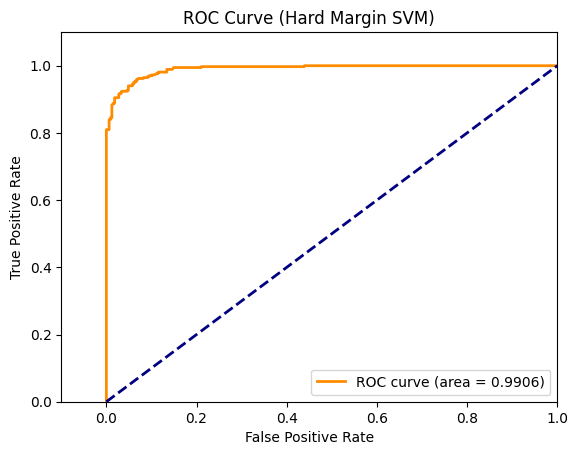

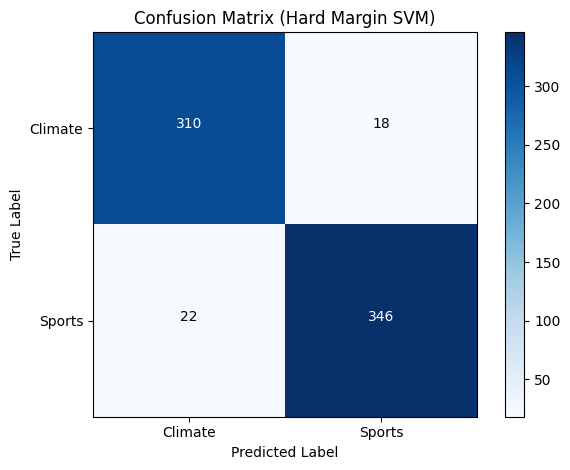

Accuracy:  0.9425287356321839
Precision:  0.9505494505494505
Recall:  0.9402173913043478
F1 Score:  0.9453551912568307


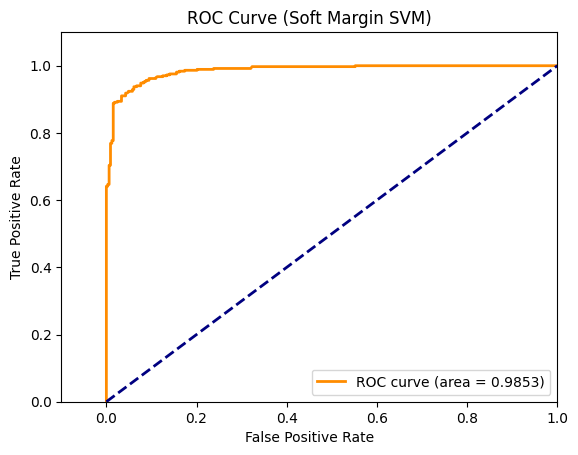

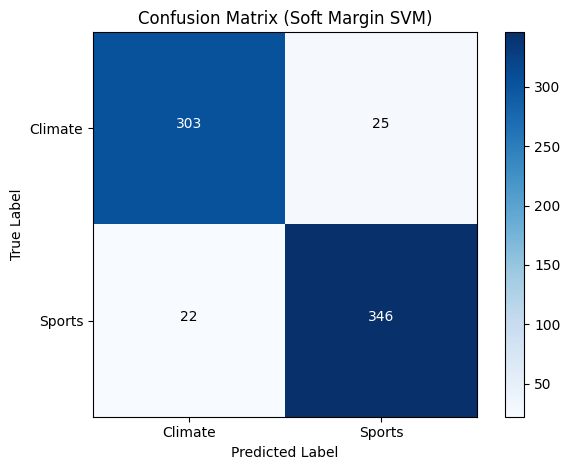

Accuracy:  0.9324712643678161
Precision:  0.9326145552560647
Recall:  0.9402173913043478
F1 Score:  0.9364005412719891


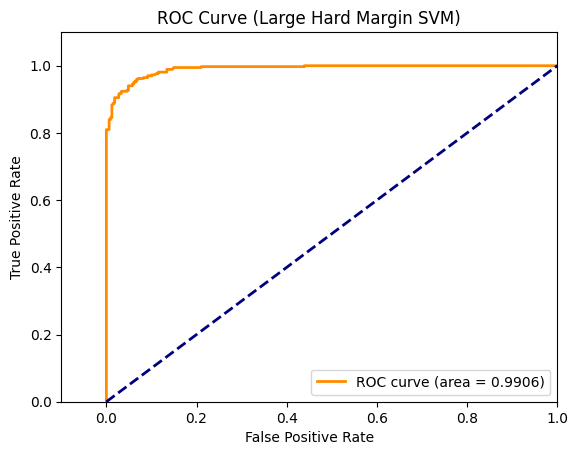

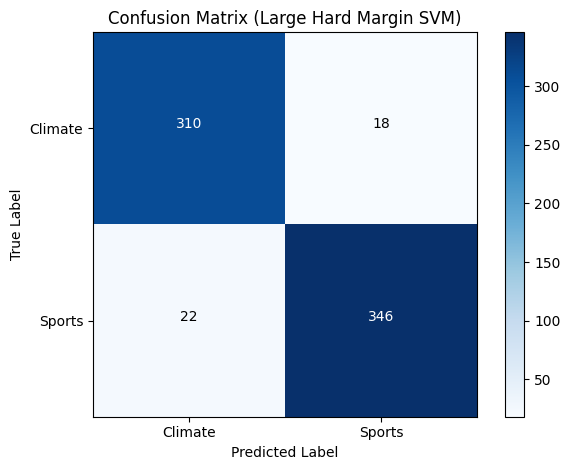

Accuracy:  0.9425287356321839
Precision:  0.9505494505494505
Recall:  0.9402173913043478
F1 Score:  0.9453551912568307


In [266]:
# Imports for the metrics
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc
)

# Function to plot the ROC curve
def plot_roc_curve(fpr, tpr, title):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.1, 1.0])
    plt.ylim([0.0, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Function to plot the confusion matrix
def plot_confusion_matrix(Y_test, Y_test_pred, title, class_names=['Climate', 'Sports'], normalize=False):
    # Compute confusion matrix
    cm = confusion_matrix(Y_test, Y_test_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize row-wise
    
    # Plot the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    # Add class labels to axes
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # Add counts or percentages as text
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment='center',
                     color='white' if cm[i, j] > thresh else 'black',)

    # Add labels and grid
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.grid(False)
    plt.show()

# Function to print the metrics
def print_metrics(Y_test, Y_test_pred):
    print("Accuracy: ", accuracy_score(Y_test, Y_test_pred))
    print("Precision: ", precision_score(Y_test, Y_test_pred))
    print("Recall: ", recall_score(Y_test, Y_test_pred))
    print("F1 Score: ", f1_score(Y_test, Y_test_pred))

# Calculate the probabilities for the ROC curve
hard_probs = hard_margin_svm.decision_function(X_test_LSI)
soft_probs = soft_margin_svm.decision_function(X_test_LSI)
large_hard_probs = large_hard_margin_svm.decision_function(X_test_LSI)

# Calculate the FPR and TPR for the ROC curve
fpr_hard, tpr_hard, _ = roc_curve(Y_test, hard_probs)
fpr_soft, tpr_soft, _ = roc_curve(Y_test, soft_probs)
fpr_large_hard, tpr_large_hard, _ = roc_curve(Y_test, large_hard_probs)

# Hard margin SVM ROC, confusion matrix, and metrics
plot_roc_curve(fpr_hard, tpr_hard, 'ROC Curve (Hard Margin SVM)')
plot_confusion_matrix(Y_test, Y_test_pred_hard, 'Confusion Matrix (Hard Margin SVM)')
print_metrics(Y_test, Y_test_pred_hard)

# Soft margin SVM ROC, confusion matrix, and metrics
plot_roc_curve(fpr_soft, tpr_soft, 'ROC Curve (Soft Margin SVM)')
plot_confusion_matrix(Y_test, Y_test_pred_soft, 'Confusion Matrix (Soft Margin SVM)')
print_metrics(Y_test, Y_test_pred_soft)

# Large Hard margin SVM ROC, confusion matrix, and metrics
plot_roc_curve(fpr_large_hard, tpr_large_hard, 'ROC Curve (Large Hard Margin SVM)')
plot_confusion_matrix(Y_test, Y_test_pred_large_hard, 'Confusion Matrix (Large Hard Margin SVM)')
print_metrics(Y_test, Y_test_pred_large_hard)

**QUESTIONS**
- Plot the ROC curve, report the confusion matrix and calculate the accuracy, recall,
precision and F-1 score of both SVM classifiers on the testing set. Which one performs
better? What about for γ = 100000?
- What happens for the soft margin SVM? Why is the case? Analyze in terms of the
confusion matrix.
  - Does the ROC curve reflect the performance of the soft-margin SVM? Why?

**Answers**
- Between the soft and hard svm, the hard svm performs slightly better (based on the confusion matrices). The extremely hard margin svm (1000) performs about equally as well as the hard margin svm (100) (k-value = 25).
- In general, hard margin svm is optimal for data that is very easily linearly seperable. On the other hand, soft margin svm is better for data that is not as easily linearly seperable. Soft margin svm tolerates misclassifications at a higher rate (which helps the model generalize). This leads to an increased rate in false positives (as seen in the ouput). The soft margin svm has a higher rate of false positives - sen in the confusion matrix(but it seems our data is pretty linearly seperable at lower dimensional space so both SVM's perform well).
- The ROC curve does not model these performance metrics very well because it is summarizing the ouput. To see the difference in performance we need to use the confusion matrix which highlights the erros in prediction much better. The ROC curve gives us a hint that the had margin is better (area under curve) but we need to analyze the confusion matrix to make sense of the output fully.

**Question**
- Use cross-validation to choose γ (use average validation 3 accuracy to compare): Using a
5-fold cross-validation, find the best value of the parameter γ in the range {10k| − 3 ≤ k ≤
6, k ∈ Z}. Again, plot the ROC curve and report the confusion matrix and calculate the
accuracy, recall precision and F-1 score of this best SVM.

In [272]:
# Beginning of code for question 5.2
from sklearn.model_selection import cross_val_score

# Define gamma selection range
gammas = [10**k for k in range(-3, 7)]

best_gamma = None
best_score = 0

for gamma in gammas:
    # Define the SVM model
    svm = LinearSVC(C=gamma, random_state=42)
    
    # Fit the model
    svm.fit(X_train_LSI, Y_train)

    # Predict the test set
    # predict = svm.predict(X_test_LSI)

    # Calculate the cross-validation score
    scores = cross_val_score(svm, X_train_LSI, Y_train, cv=5, scoring='accuracy')

    print("Gamma: ", gamma, "   Mean Score: ", scores.mean())

    # Update the best score and gamma
    if scores.mean() > best_score:
        best_score = scores.mean()
        best_gamma = gamma

print("\nBest Gamma: ", best_gamma)

Gamma:  0.001    Mean Score:  0.9348920863309352
Gamma:  0.01    Mean Score:  0.935611510791367
Gamma:  0.1    Mean Score:  0.9420863309352517
Gamma:  1    Mean Score:  0.9478417266187051
Gamma:  10    Mean Score:  0.952158273381295
Gamma:  100    Mean Score:  0.9525179856115107
Gamma:  1000    Mean Score:  0.9525179856115107
Gamma:  10000    Mean Score:  0.9525179856115107
Gamma:  100000    Mean Score:  0.9525179856115107
Gamma:  1000000    Mean Score:  0.9525179856115107

Best Gamma:  100


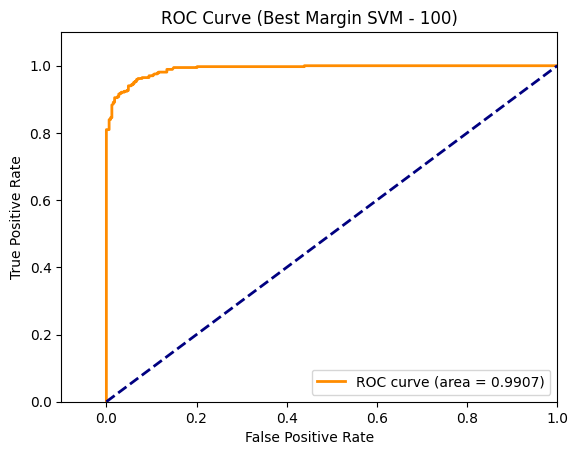

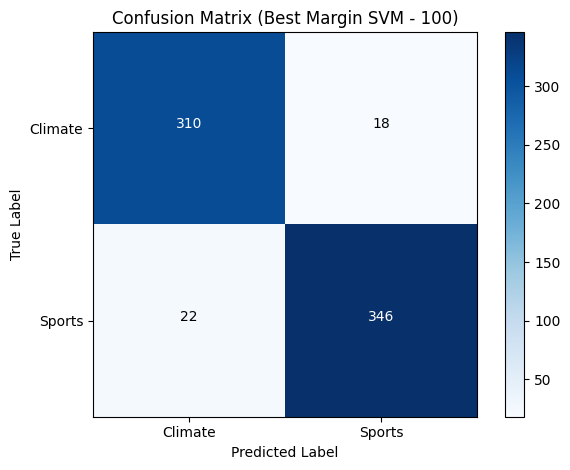

Accuracy:  0.9425287356321839
Precision:  0.9505494505494505
Recall:  0.9402173913043478
F1 Score:  0.9453551912568307


In [273]:
# Best margin SVM plots + metrics

# Best margin SVM
best_margin_svm = LinearSVC(C=best_gamma, random_state=42)
best_margin_svm.fit(X_train_LSI, Y_train)

Y_test_pred_best = best_margin_svm.predict(X_test_LSI)

# Calculate the probabilities for the ROC curve
best_probs = best_margin_svm.decision_function(X_test_LSI)

# Calculate the FPR and TPR for the ROC curve
fpr_best, tpr_best, _ = roc_curve(Y_test, best_probs)

# Best margin SVM ROC, confusion matrix, and metrics
plot_roc_curve(fpr_best, tpr_best, 'ROC Curve (Best Margin SVM - 100)')
plot_confusion_matrix(Y_test, Y_test_pred_best, 'Confusion Matrix (Best Margin SVM - 100)')
print_metrics(Y_test, Y_test_pred_best)

### QUESTION 6: Evaluate a logistic classifier:
- Train a logistic classifier without regularization (you may need to come up with some way to
approximate this if you use sklearn.linear model.LogisticRegression); plot the ROC
curve and report the confusion matrix and calculate the accuracy, recall precision and F-1
score of this classifier on the testing set.

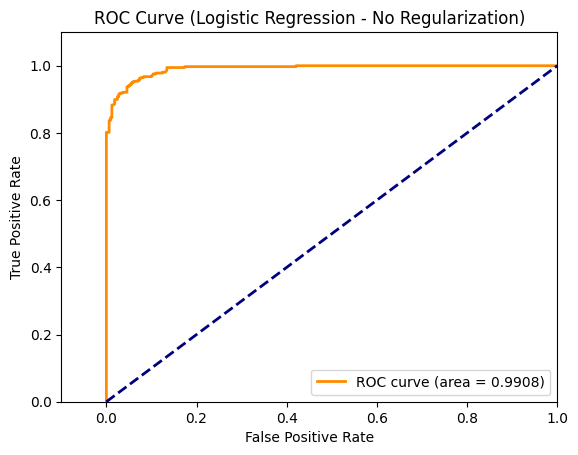

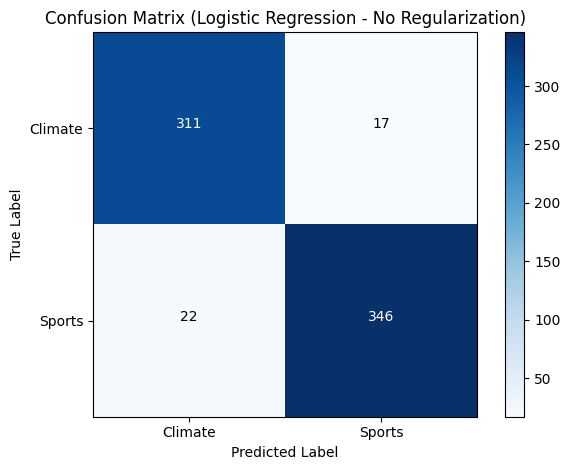

Accuracy:  0.9439655172413793
Precision:  0.953168044077135
Recall:  0.9402173913043478
F1 Score:  0.9466484268125855


In [278]:
# Code for Question 6.1

from sklearn.linear_model import LogisticRegression

# Train the logistic regression model wo penalty
log_class_wo_reg = LogisticRegression(random_state=42, penalty=None)
log_class_wo_reg.fit(X_train_LSI, Y_train)

# Predict the test set
Y_test_pred_log_class_wo_reg = log_class_wo_reg.predict(X_test_LSI)

# Calculate the probabilities for the ROC curve
log_class_wo_reg_probs = log_class_wo_reg.decision_function(X_test_LSI)

# Calculate the FPR and TPR for the ROC curve
fpr_log_class_wo_reg, tpr_log_class_wo_reg, _ = roc_curve(Y_test, log_class_wo_reg_probs)

# Logistic Regression (No Regularization) ROC, confusion matrix, and metrics
plot_roc_curve(fpr_log_class_wo_reg, tpr_log_class_wo_reg, 'ROC Curve (Logistic Regression - No Regularization)')
plot_confusion_matrix(Y_test, Y_test_pred_log_class_wo_reg, 'Confusion Matrix (Logistic Regression - No Regularization)')
print_metrics(Y_test, Y_test_pred_log_class_wo_reg)

**Question**
- Find the optimal regularization coefficient:
  - Using 5-fold cross-validation on the dimension-reduced-by-SVD training data, find the op-
timal regularization strength in the range {10k|−5 ≤ k ≤ 5, k ∈ Z} for logistic regression
with L1 regularization and logistic regression with L2 regularization, respectively.
  - Compare the performance (accuracy, precision, recall and F-1 score) of 3 logistic classi-
fiers: w/o regularization, w/ L1 regularization and w/ L2 regularization (with the best
parameters you found from the part above), using test data.

In [307]:
# Code for question 6.2.1

# Define gamma selection range
reg_strengths = [10**k for k in range(-5, 5)]

def cross_validation(penalty):
    best_reg_strength = None
    best_score = 0
    best_Y_test_pred = None

    for reg_strength in reg_strengths:
        # Define the classifier
        if penalty == None:
            classifier = LogisticRegression(random_state=42, penalty=penalty, C=reg_strength)
        else:
            classifier = LogisticRegression(random_state=42, penalty=penalty, C=reg_strength, solver='liblinear')

        # Fit the model
        classifier.fit(X_train_LSI, Y_train)

        # Predict the test set
        Y_test_pred_temp = classifier.predict(X_test_LSI)

        # Calculate the cross-validation score
        scores = cross_val_score(classifier, X_train_LSI, Y_train, cv=5, scoring='accuracy')

        print("Regularization Strength: ", reg_strength, "   Mean Score: ", scores.mean())

        # Update the best score and reg_strength
        if scores.mean() > best_score:
            best_score = scores.mean()
            best_reg_strength = reg_strength
            best_Y_test_pred = Y_test_pred_temp
    
    print("\nBest Regularization Strength: ", best_reg_strength)
    
    return best_Y_test_pred, best_reg_strength

print("-------------- L1 Regularization --------------")
Y_test_pred_log_class_l1_reg, best_l1_reg_strength = cross_validation('l1')

print("\n-------------- L2 Regularization --------------")
Y_test_pred_log_class_l2_reg, best_l2_reg_strength = cross_validation('l2')

-------------- L1 Regularization --------------
Regularization Strength:  1e-05    Mean Score:  0.5028776978417266
Regularization Strength:  0.0001    Mean Score:  0.5028776978417266
Regularization Strength:  0.001    Mean Score:  0.5028776978417266
Regularization Strength:  0.01    Mean Score:  0.5028776978417266
Regularization Strength:  0.1    Mean Score:  0.9248201438848922
Regularization Strength:  1    Mean Score:  0.9424460431654677
Regularization Strength:  10    Mean Score:  0.9528776978417266
Regularization Strength:  100    Mean Score:  0.952158273381295
Regularization Strength:  1000    Mean Score:  0.952158273381295
Regularization Strength:  10000    Mean Score:  0.952158273381295

Best Regularization Strength:  10

-------------- L2 Regularization --------------
Regularization Strength:  1e-05    Mean Score:  0.8582733812949641
Regularization Strength:  0.0001    Mean Score:  0.8669064748201439
Regularization Strength:  0.001    Mean Score:  0.9086330935251798
Regularizat

In [298]:
# Code for question 6.2.2

print("-------------- Metrics for No Regularization --------------")
print_metrics(Y_test, Y_test_pred_log_class_wo_reg)

print("\n-------------- Metrics for L1 Regularization (Regulization Strength = 10) --------------")
print_metrics(Y_test, Y_test_pred_log_class_l1_reg)

print("\n-------------- Metrics for L2 Regularization (Regulization Strength = 100) --------------")
print_metrics(Y_test, Y_test_pred_log_class_l2_reg)

-------------- Metrics for No Regularization --------------
Accuracy:  0.9439655172413793
Precision:  0.953168044077135
Recall:  0.9402173913043478
F1 Score:  0.9466484268125855

-------------- Metrics for L1 Regularization (Regulization Strength = 10) --------------
Accuracy:  0.9454022988505747
Precision:  0.9508196721311475
Recall:  0.9456521739130435
F1 Score:  0.9482288828337875

-------------- Metrics for L2 Regularization (Regulization Strength = 100) --------------
Accuracy:  0.9482758620689655
Precision:  0.9510869565217391
Recall:  0.9510869565217391
F1 Score:  0.9510869565217391


**Question**
- How does the regularization parameter affect the test error? How are the learnt coeffi-
cients affected? Why might one be interested in each type of regularization?
- Both logistic regression and linear SVM are trying to classify data points using a linear
decision boundary. What is the difference between their ways to find this boundary? Why
do their performances differ? Is this difference statistically significant?

**Answer**
- Regularization (in general) helps to reduce overfitting and imroves generalization. L1 regularization encourages sparsity in coefficients (selects important features by driving some coefficients to 0). L2 regularization shrinks the coeffeicients uniformly (balances features). Overall, given the test results L2 regularization slightly outperformed L1 regularization (both outperformed no regularization). l2 regularizations better balance feature contributions (without elimination) shoing an improved accuracy measurement and better rsults overall. Depending on use case, all of these forms of regularization could be very useful. In some cases feature removal is very helpful (getting rid of non-useful features - L1). in the other hand, feature balancing seen here is useful as we can see there aren't that many unimportant features (based on results).
- log regression:
  - minimizes log-loss and predicts probabilities.
  - suitable for datasets that have a lot of overlapping between classes. Sensitive to outliers due to maximizing the margin.
- Linear SVM:
  - maximizes the margin between the two classes and minimizes hinge loss (misclassification)
  - best for well seperated classes - Not as sensitive to outliers
- There performances differ fue to the descriptions above (specifically the effect of outliers). This does not have a large effect statistically on this dataset as their metrics are about the same.

### QUESTION 7: Evaluate and profile a Naive Bayes classifier: 
Train a GaussianNB classifier; plot the ROC curve and report the confusion matrix and calculate the accuracy, recall, precision and
F-1 score of this classifier on the testing set.

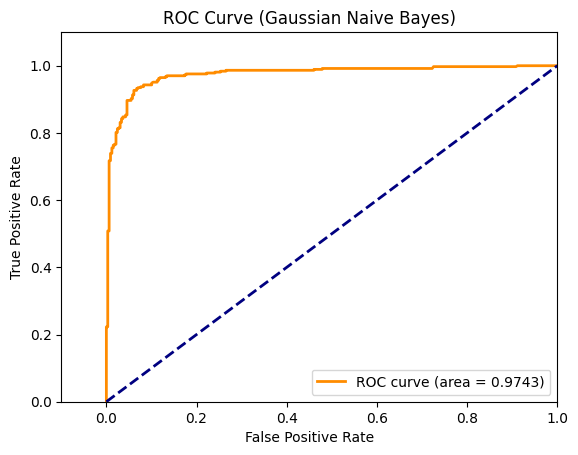

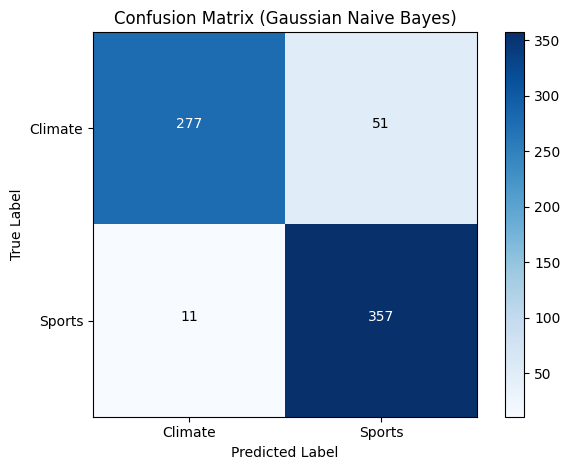

Accuracy:  0.9109195402298851
Precision:  0.875
Recall:  0.970108695652174
F1 Score:  0.9201030927835051


In [301]:
# Code for Question 7

from sklearn.naive_bayes import GaussianNB

# Train the Gaussian Naive Bayes model
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train_LSI, Y_train)

# Predict the test set
Y_test_pred_gaussian_nb = gaussian_nb.predict(X_test_LSI)

# Calculate the probabilities for the ROC curve
gaussian_nb_probs = gaussian_nb.predict_proba(X_test_LSI)[:, 1]

# Calculate the FPR and TPR for the ROC curve
fpr_gaussian_nb, tpr_gaussian_nb, _ = roc_curve(Y_test, gaussian_nb_probs)

# Gaussian Naive Bayes ROC, confusion matrix, and metrics
plot_roc_curve(fpr_gaussian_nb, tpr_gaussian_nb, 'ROC Curve (Gaussian Naive Bayes)')
plot_confusion_matrix(Y_test, Y_test_pred_gaussian_nb, 'Confusion Matrix (Gaussian Naive Bayes)')
print_metrics(Y_test, Y_test_pred_gaussian_nb)

### QUESTION 8: In this part, you will attempt to find the best model for binary classification.
- Construct a Pipeline that performs feature extraction, dimensionality reduction and classifi-
cation;
- The evaluation of each combination is performed with 5-fold cross-validation (use the average
validation set accuracy across folds).
- In addition to any other hyperparameters you choose, your gridsearch must at least include:
- What are the 5 best combinations? Report their performances on the testing set.

In [316]:
# Code for Question 8

from nltk.stem import PorterStemmer

# Setting the random seed variables for repeatability of results
np.random.seed(42)
random.seed(42)

# Class for loading the data
class load_data:
    def __init__(self, path):
        self.df = pd.read_csv(path)
        self.df.head()

    def load_data(self):
        return self.df
    
    def split_data(self):
        train, test = train_test_split(self.df[["full_text","root_label"]], test_size=0.2)
        return train, test
    
    def clean_data(self, data):
        data['full_text'] = data['full_text'].map(clean)
        return data
    
    def update(self):
        # Split the data into training and testing sets
        train, test = self.split_data()
        # Clean the data
        train, test = self.clean_data(train), self.clean_data(test)

        return train, test

# Class for Feature Extraction
class FeatureExtraction:
    def __init__(self, min_df):
        self.min_df = min_df # Minimum document frequency
        self.count_vect = CountVectorizer(min_df=min_df, stop_words='english') # Initialize the CountVectorizer
        self.tfidf_transformer = TfidfTransformer()  # Initialize the TF-IDF transformer

    # Lemmatize and remove terms that are numbers
    def lemmatize(self, data):
        # Initialize the WordNetLemmatizer
        wnl = nltk.wordnet.WordNetLemmatizer()

        lemmatized_output = []
        for element in data:
            lemmatized_sentence = ' '.join([
                wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
                for word, tag in nltk.pos_tag(nltk.word_tokenize(element))
                if not re.match(r'^\d+(\.\d+)?$', word)
            ])
            lemmatized_output.append(lemmatized_sentence)

        return lemmatized_output
    
    # Function for stemming and removing numbers
    def stem_data(self, data):
        # Initialize the PorterStemmer
        ps = PorterStemmer()

        stemmed_output = []
        for element in data:
            stemmed_sentence = ' '.join([
                ps.stem(word.lower())  # Stem each word
                for word, tag in nltk.pos_tag(nltk.word_tokenize(element))
                if not re.match(r'^\d+(\.\d+)?$', word)  # Exclude numbers
            ])
            stemmed_output.append(stemmed_sentence)

        return stemmed_output
    
    def update(self, train, test):
        # Lemmatize the full_text feature in the training and testing set (remove #'s)
        train_lemmatized = self.lemmatize(train['full_text'])
        test_lemmatized = self.lemmatize(test['full_text'])

        # Stem the full_text feature in the training and testing set (remove #'s)
        train_stemmed = self.stem_data(train['full_text'])
        test_stemmed = self.stem_data(test['full_text'])

        # Vectorization of lemmitized data
        X_train_counts_lemmatized = self.count_vect.fit_transform(train_lemmatized)
        X_test_counts_lemmatized = self.count_vect.transform(test_lemmatized)

        # Vectorization of stemmed data
        X_train_counts_stemmed = self.count_vect.fit_transform(train_stemmed)
        X_test_counts_stemmed = self.count_vect.transform(test_stemmed)

        # TF-IDF transformation of lemmitized data
        X_train_tfidf_lemmatized = self.tfidf_transformer.fit_transform(X_train_counts_lemmatized)
        X_test_tfidf_lemmatized = self.tfidf_transformer.transform(X_test_counts_lemmatized)

        # TF-IDF transformation of stemmed data
        X_train_tfidf_stemmed = self.tfidf_transformer.fit_transform(X_train_counts_stemmed)
        X_test_tfidf_stemmed = self.tfidf_transformer.transform(X_test_counts_stemmed)

        return X_train_tfidf_lemmatized, X_test_tfidf_lemmatized, X_train_tfidf_stemmed, X_test_tfidf_stemmed


# Class for Dimensionality Rerduction
class DimensionalityReduction:
    def __init__(self, k, X_train_tfidf, X_test_tfidf):
        self.k = k  # Number of components for LSI and NMF
        self.X_train_tfidf = X_train_tfidf  # Training set TF-IDF matrix
        self.X_test_tfidf = X_test_tfidf  # Testing set TF-IDF matrix

    # Function for LSI
    def custom_LSI(self):
        svd = TruncatedSVD(n_components=self.k, random_state=42)
        X_train_LSI = svd.fit_transform(self.X_train_tfidf)
        X_test_LSI = svd.transform(self.X_test_tfidf)
        X_approx = svd.inverse_transform(X_train_LSI)
        return X_train_LSI, X_test_LSI, np.sum(np.array(self.X_train_tfidf - X_approx)**2)
    
    # Function for NMF
    def custom_NMF(self):
        model = NMF(n_components=self.k, init='random', random_state=42)
        X_train_NMF = model.fit_transform(self.X_train_tfidf)
        X_test_NMF = model.transform(self.X_test_tfidf)
        H = model.components_
        return X_train_NMF, X_test_NMF, np.sum(np.array(self.X_train_tfidf - X_train_NMF.dot(H))**2)

# Functions for Classification
class Classifier:
    def __init__(self, best_gamma, Y_train, best_l1_reg_strength, best_l2_reg_strength):
        self.best_gamma = best_gamma  # Best gamma value for SVM
        self.Y_train = Y_train  # Training set labels
        self.best_l1_reg_strength = best_l1_reg_strength
        self.best_l2_reg_strength = best_l2_reg_strength

    # SVM
    def custom_SVM(self, X_train):
        # Create and fit the SVM model
        svm = LinearSVC(C=self.best_gamma, random_state=42).fit(X_train, self.Y_train)

        # Calculate the k-fold cross-validation score
        scores = cross_val_score(svm, X_train, self.Y_train, cv=5, scoring='accuracy')

        # Return the mean score
        return scores.mean()

    # Logistic Regression
    def custom_LogisticRegression(self, X_train):
        # Define the log regression classifier
        classifier_l1 = LogisticRegression(random_state=42, penalty='l1', C=self.best_l1_reg_strength, solver='liblinear').fit(X_train, self.Y_train)
        classifier_l2 = LogisticRegression(random_state=42, penalty='l2', C=self.best_l2_reg_strength, solver='liblinear').fit(X_train, self.Y_train)

        # Calculate the k-fold cross-validation scores
        scores_l1 = cross_val_score(classifier_l1, X_train, self.Y_train, cv=5, scoring='accuracy')
        scores_l2 = cross_val_score(classifier_l2, X_train, self.Y_train, cv=5, scoring='accuracy')

        # Return the mean scores
        return scores_l1.mean(), scores_l2.mean()

    #GaussianNB
    def custom_GaussianNB(self, X_train):
        gaussian_nb = GaussianNB()
        gaussian_nb.fit(X_train, self.Y_train)

        # Calculate the k-fold cross-validation score
        scores = cross_val_score(gaussian_nb, X_train, self.Y_train, cv=5, scoring='accuracy')

        # Return the mean score
        return scores.mean()


In [317]:
# Runnning the pipeline

# Load the data
data_loader = load_data("Project1-ClassificationDataset.csv")
train, test = data_loader.update()

# Pipeline parameter definition
min_dfs = [2, 5]
ks = [5, 30, 100]

top_5_scores = []

# Outer loop - iterate over min_df values for feature extraction
for min_df in min_dfs:
    feature_extractor = FeatureExtraction(min_df)
    X_train_tfidf_lemmatized, X_test_tfidf_lemmatized, X_train_tfidf_stemmed, X_test_tfidf_stemmed = feature_extractor.update(train, test)

    # Dimensionality Reduction
    for k in ks:
        # Create the LSI and NMF objects
        DimensionalityReduction_Stemmed = DimensionalityReduction(k, X_train_tfidf_stemmed, X_test_tfidf_stemmed)
        DimensionalityReduction_Lemmatized = DimensionalityReduction(k, X_train_tfidf_lemmatized, X_test_tfidf_lemmatized)

        # Perform LSI and NMF on lemmatized and stemmed data
        X_train_LSI_lemmatized, _, _ = DimensionalityReduction_Lemmatized.custom_LSI()
        X_train_LSI_stemmed, _, _ = DimensionalityReduction_Stemmed.custom_LSI()
        X_train_NMF_lemmatized, _, _ = DimensionalityReduction_Lemmatized.custom_NMF()
        X_train_NMF_stemmed, _, _ = DimensionalityReduction_Stemmed.custom_NMF()

        # Create classifier object
        classifier = Classifier(best_gamma, Y_train, best_l1_reg_strength, best_l2_reg_strength)

        # Perform SVM classification
        # svm_score_LSI_lemmatized = classifier.custom_SVM(X_train_LSI_lemmatized)
        # svm_score_LSI_stemmed = classifier.custom_SVM(X_train_LSI_stemmed)
        # svm_score_NMF_lemmatized = classifier.custom_SVM(X_train_NMF_lemmatized)
        # svm_score_NMF_stemmed = classifier.custom_SVM(X_train_NMF_stemmed)

        # # Perform Logistic Regression classification
        # log_score_l1_LSI_lemmatized, log_score_l2_LSI_lemmatized = classifier.custom_LogisticRegression(X_train_LSI_lemmatized)
        # log_score_l1_LSI_stemmed, log_score_l2_LSI_stemmed = classifier.custom_LogisticRegression(X_train_LSI_stemmed)
        # log_score_l1_NMF_lemmatized, log_score_l2_NMF_lemmatized = classifier.custom_LogisticRegression(X_train_NMF_lemmatized)
        # log_score_l1_NMF_stemmed, log_score_l2_NMF_stemmed = classifier.custom_LogisticRegression(X_train_NMF_stemmed)

        # # Perform Gaussian Naive Bayes classification
        # gaussian_nb_score_LSI_lemmatized = classifier.custom_GaussianNB(X_train_LSI_lemmatized)
        # gaussian_nb_score_LSI_stemmed = classifier.custom_GaussianNB(X_train_LSI_stemmed)
        # gaussian_nb_score_NMF_lemmatized = classifier.custom_GaussianNB(X_train_NMF_lemmatized)
        # gaussian_nb_score_NMF_stemmed = classifier.custom_GaussianNB(X_train_NMF_stemmed)

        # # Print the results
        # print("---------------- Min_df: ", min_df, "   k: ", k, " ----------------")
        # print("SVM Scores:")
        # print("LSI Lemmatized: ", svm_score_LSI_lemmatized)
        # print("LSI Stemmed: ", svm_score_LSI_stemmed)
        # print("NMF Lemmatized: ", svm_score_NMF_lemmatized)
        # print("NMF Stemmed: ", svm_score_NMF_stemmed)

        # print("\nLogistic Regression Scores:")
        # print("L1 LSI Lemmatized: ", log_score_l1_LSI_lemmatized)
        # print("L2 LSI Lemmatized: ", log_score_l2_LSI_lemmatized)
        # print("L1 LSI Stemmed: ", log_score_l1_LSI_stemmed)
        # print("L2 LSI Stemmed: ", log_score_l2_LSI_stemmed)
        # print("L1 NMF Lemmatized: ", log_score_l1_NMF_lemmatized)
        # print("L2 NMF Lemmatized: ", log_score_l2_NMF_lemmatized)
        # print("L1 NMF Stemmed: ", log_score_l1_NMF_stemmed)
        # print("L2 NMF Stemmed: ", log_score_l2_NMF_stemmed)

        # print("\nGaussian Naive Bayes Scores:")
        # print("LSI Lemmatized: ", gaussian_nb_score_LSI_lemmatized)
        # print("LSI Stemmed: ", gaussian_nb_score_LSI_stemmed)
        # print("NMF Lemmatized: ", gaussian_nb_score_NMF_lemmatized)
        # print("NMF Stemmed: ", gaussian_nb_score_NMF_stemmed)

        # print("\n")

        # Perform SVM classification
        scores = [
            (classifier.custom_SVM(X_train_LSI_lemmatized), "SVM", "LSI", "Lemmatized", min_df, k),
            (classifier.custom_SVM(X_train_LSI_stemmed), "SVM", "LSI", "Stemmed", min_df, k),
            (classifier.custom_SVM(X_train_NMF_lemmatized), "SVM", "NMF", "Lemmatized", min_df, k),
            (classifier.custom_SVM(X_train_NMF_stemmed), "SVM", "NMF", "Stemmed", min_df, k),
            (classifier.custom_LogisticRegression(X_train_LSI_lemmatized)[0], "LogReg (L1)", "LSI", "Lemmatized", min_df, k),
            (classifier.custom_LogisticRegression(X_train_LSI_lemmatized)[1], "LogReg (L2)", "LSI", "Lemmatized", min_df, k),
            (classifier.custom_LogisticRegression(X_train_LSI_stemmed)[0], "LogReg (L1)", "LSI", "Stemmed", min_df, k),
            (classifier.custom_LogisticRegression(X_train_LSI_stemmed)[1], "LogReg (L2)", "LSI", "Stemmed", min_df, k),
            (classifier.custom_LogisticRegression(X_train_NMF_lemmatized)[0], "LogReg (L1)", "NMF", "Lemmatized", min_df, k),
            (classifier.custom_LogisticRegression(X_train_NMF_lemmatized)[1], "LogReg (L2)", "NMF", "Lemmatized", min_df, k),
            (classifier.custom_LogisticRegression(X_train_NMF_stemmed)[0], "LogReg (L1)", "NMF", "Stemmed", min_df, k),
            (classifier.custom_LogisticRegression(X_train_NMF_stemmed)[1], "LogReg (L2)", "NMF", "Stemmed", min_df, k),
            (classifier.custom_GaussianNB(X_train_LSI_lemmatized), "GaussianNB", "LSI", "Lemmatized", min_df, k),
            (classifier.custom_GaussianNB(X_train_LSI_stemmed), "GaussianNB", "LSI", "Stemmed", min_df, k),
            (classifier.custom_GaussianNB(X_train_NMF_lemmatized), "GaussianNB", "NMF", "Lemmatized", min_df, k),
            (classifier.custom_GaussianNB(X_train_NMF_stemmed), "GaussianNB", "NMF", "Stemmed", min_df, k),
        ]

        print(scores)

        # Add all scores to the top_5_scores list
        for score in scores:
            top_5_scores.append(score)

# Sort the scores in descending order and keep the top 5
top_5_scores = sorted(top_5_scores, key=lambda x: x[0], reverse=True)[:5]

# Print the top 5 scores with their parameters
print("\nTop 5 Scores:")
for score, classifier, reduction_method, processing, min_df, k in top_5_scores:
    print(f"Score: {score:.4f}, Classifier: {classifier}, Reduction: {reduction_method}, Processing: {processing}, Min_df: {min_df}, k: {k}")


[(np.float64(0.9298561151079137), 'SVM', 'LSI', 'Lemmatized', 2, 5), (np.float64(0.9255395683453237), 'SVM', 'LSI', 'Stemmed', 2, 5), (np.float64(0.9223021582733812), 'SVM', 'NMF', 'Lemmatized', 2, 5), (np.float64(0.9276978417266187), 'SVM', 'NMF', 'Stemmed', 2, 5), (np.float64(0.9316546762589928), 'LogReg (L1)', 'LSI', 'Lemmatized', 2, 5), (np.float64(0.9316546762589928), 'LogReg (L2)', 'LSI', 'Lemmatized', 2, 5), (np.float64(0.9280575539568344), 'LogReg (L1)', 'LSI', 'Stemmed', 2, 5), (np.float64(0.9276978417266187), 'LogReg (L2)', 'LSI', 'Stemmed', 2, 5), (np.float64(0.9251798561151079), 'LogReg (L1)', 'NMF', 'Lemmatized', 2, 5), (np.float64(0.9251798561151079), 'LogReg (L2)', 'NMF', 'Lemmatized', 2, 5), (np.float64(0.9266187050359711), 'LogReg (L1)', 'NMF', 'Stemmed', 2, 5), (np.float64(0.9276978417266186), 'LogReg (L2)', 'NMF', 'Stemmed', 2, 5), (np.float64(0.8557553956834532), 'GaussianNB', 'LSI', 'Lemmatized', 2, 5), (np.float64(0.8633093525179858), 'GaussianNB', 'LSI', 'Stemmed

/Users/tilboon/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[(np.float64(0.9525179856115107), 'SVM', 'LSI', 'Lemmatized', 2, 30), (np.float64(0.9553956834532376), 'SVM', 'LSI', 'Stemmed', 2, 30), (np.float64(0.9464028776978417), 'SVM', 'NMF', 'Lemmatized', 2, 30), (np.float64(0.9478417266187049), 'SVM', 'NMF', 'Stemmed', 2, 30), (np.float64(0.9550359712230214), 'LogReg (L1)', 'LSI', 'Lemmatized', 2, 30), (np.float64(0.953956834532374), 'LogReg (L2)', 'LSI', 'Lemmatized', 2, 30), (np.float64(0.9557553956834532), 'LogReg (L1)', 'LSI', 'Stemmed', 2, 30), (np.float64(0.956474820143885), 'LogReg (L2)', 'LSI', 'Stemmed', 2, 30), (np.float64(0.9442446043165468), 'LogReg (L1)', 'NMF', 'Lemmatized', 2, 30), (np.float64(0.9442446043165468), 'LogReg (L2)', 'NMF', 'Lemmatized', 2, 30), (np.float64(0.9510791366906475), 'LogReg (L1)', 'NMF', 'Stemmed', 2, 30), (np.float64(0.9471223021582734), 'LogReg (L2)', 'NMF', 'Stemmed', 2, 30), (np.float64(0.8964028776978417), 'GaussianNB', 'LSI', 'Lemmatized', 2, 30), (np.float64(0.89568345323741), 'GaussianNB', 'LSI',

/Users/tilboon/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[(np.float64(0.9586330935251798), 'SVM', 'LSI', 'Lemmatized', 2, 100), (np.float64(0.9568345323741007), 'SVM', 'LSI', 'Stemmed', 2, 100), (np.float64(0.9543165467625899), 'SVM', 'NMF', 'Lemmatized', 2, 100), (np.float64(0.960431654676259), 'SVM', 'NMF', 'Stemmed', 2, 100), (np.float64(0.9622302158273381), 'LogReg (L1)', 'LSI', 'Lemmatized', 2, 100), (np.float64(0.9611510791366907), 'LogReg (L2)', 'LSI', 'Lemmatized', 2, 100), (np.float64(0.9582733812949641), 'LogReg (L1)', 'LSI', 'Stemmed', 2, 100), (np.float64(0.9597122302158274), 'LogReg (L2)', 'LSI', 'Stemmed', 2, 100), (np.float64(0.9557553956834532), 'LogReg (L1)', 'NMF', 'Lemmatized', 2, 100), (np.float64(0.9507194244604316), 'LogReg (L2)', 'NMF', 'Lemmatized', 2, 100), (np.float64(0.9568345323741008), 'LogReg (L1)', 'NMF', 'Stemmed', 2, 100), (np.float64(0.9550359712230216), 'LogReg (L2)', 'NMF', 'Stemmed', 2, 100), (np.float64(0.9348920863309352), 'GaussianNB', 'LSI', 'Lemmatized', 2, 100), (np.float64(0.9212230215827338), 'Gau

/Users/tilboon/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[(np.float64(0.9535971223021582), 'SVM', 'LSI', 'Lemmatized', 5, 30), (np.float64(0.9557553956834534), 'SVM', 'LSI', 'Stemmed', 5, 30), (np.float64(0.95), 'SVM', 'NMF', 'Lemmatized', 5, 30), (np.float64(0.9514388489208633), 'SVM', 'NMF', 'Stemmed', 5, 30), (np.float64(0.953956834532374), 'LogReg (L1)', 'LSI', 'Lemmatized', 5, 30), (np.float64(0.9532374100719425), 'LogReg (L2)', 'LSI', 'Lemmatized', 5, 30), (np.float64(0.9557553956834534), 'LogReg (L1)', 'LSI', 'Stemmed', 5, 30), (np.float64(0.9553956834532376), 'LogReg (L2)', 'LSI', 'Stemmed', 5, 30), (np.float64(0.9521582733812949), 'LogReg (L1)', 'NMF', 'Lemmatized', 5, 30), (np.float64(0.9449640287769784), 'LogReg (L2)', 'NMF', 'Lemmatized', 5, 30), (np.float64(0.9489208633093524), 'LogReg (L1)', 'NMF', 'Stemmed', 5, 30), (np.float64(0.9471223021582734), 'LogReg (L2)', 'NMF', 'Stemmed', 5, 30), (np.float64(0.9212230215827338), 'GaussianNB', 'LSI', 'Lemmatized', 5, 30), (np.float64(0.8992805755395684), 'GaussianNB', 'LSI', 'Stemmed',

/Users/tilboon/opt/anaconda3/envs/ece219/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[(np.float64(0.9579136690647483), 'SVM', 'LSI', 'Lemmatized', 5, 100), (np.float64(0.9575539568345324), 'SVM', 'LSI', 'Stemmed', 5, 100), (np.float64(0.9575539568345324), 'SVM', 'NMF', 'Lemmatized', 5, 100), (np.float64(0.9589928057553957), 'SVM', 'NMF', 'Stemmed', 5, 100), (np.float64(0.9636690647482015), 'LogReg (L1)', 'LSI', 'Lemmatized', 5, 100), (np.float64(0.9636690647482015), 'LogReg (L2)', 'LSI', 'Lemmatized', 5, 100), (np.float64(0.9593525179856115), 'LogReg (L1)', 'LSI', 'Stemmed', 5, 100), (np.float64(0.9611510791366907), 'LogReg (L2)', 'LSI', 'Stemmed', 5, 100), (np.float64(0.9589928057553957), 'LogReg (L1)', 'NMF', 'Lemmatized', 5, 100), (np.float64(0.9575539568345324), 'LogReg (L2)', 'NMF', 'Lemmatized', 5, 100), (np.float64(0.9575539568345324), 'LogReg (L1)', 'NMF', 'Stemmed', 5, 100), (np.float64(0.95863309352518), 'LogReg (L2)', 'NMF', 'Stemmed', 5, 100), (np.float64(0.9384892086330936), 'GaussianNB', 'LSI', 'Lemmatized', 5, 100), (np.float64(0.9284172661870503), 'Gaus

### QUESTION 9: In this part, we aim to learn classifiers on the documents belonging to unique classes in the column leaf label.
Perform Naive Bayes classification and multiclass SVM classification (with both One VS One and
One VS the rest methods described above) and report the confusion matrix and calculate the
accuracy, recall, precision and F-1 score of your classifiers. How did you resolve the class
imbalance issue in the One VS the rest model?
In addition, answer the following questions:
- In the confusion matrix you should have an 10 × 10 matrix where 10 is the number of unique
labels in the column leaf label. Please make sure that the order of these labels is as
follows:

    *map_row_to_class = {0:"basketball", 1:"baseball", 2:"tennis", 3:"football", 4:"soccer", 5:"forest fire", 6:"flood", 7:"earthquake", 8:"drought", 9:"heatwave"}*

    Do you observe any structure in the confusion matrix? Are there distinct visible blocks on the
    major diagonal? What does this mean?
    
- Based on your observation from the previous part, suggest a subset of labels that should be
merged into a new larger label and recompute the accuracy and plot the confusion matrix.
How did the accuracy change in One VS One and One VS the rest?
- Does class imbalance impact the performance of the classification once some classes are
merged? Provide a resolution for the class imbalance and recompute the accuracy and plot
the confusion matrix in One VS One and One VS the rest?.

In [244]:
# Code for Question 9

### QUESTION 10: Read the paper about GLoVE embeddings - found here and answer the following subquestions:
a. Why are GLoVE embeddings trained on the ratio of co-occurrence probabilities rather than
the probabilities themselves?

b. In the two sentences: “James is running in the park.” and “James is running for the
presidency.”, would GLoVE embeddings return the same vector for the word running in both
cases? Why or why not?

c. What do you expect for the values of,
||GLoVE["left"] - $GLoVE["right"]||_2$, ||GLoVE["wife"] - $GLoVE["husband"]||_2$ and
||GLoVE["wife"] - $GLoVE["orange"]||_2$ ? Compare these values.

d. Given a word, would you rather stem or lemmatize the word before mapping it to its GLoVE
embedding?

In [245]:
# Code for Question 10

### QUESTION 11: For the binary classification task distinguishing the “sports” class and “climate” class:
a. Describe a feature engineering process that uses GLoVE word embeddings to represent each
document. You have to abide by the following rules:

- A representation of a text segment needs to have a vector dimension that CANNOT
exceed the dimension of the GLoVE embedding used per word of the segment.
- You cannot use TF-IDF scores (or any measure that requires looking at the complete
dataset) as a pre-processing routine.
- Important: In this section, feel free to use raw features from any column in the original
data file not just full text. The column keywords might be useful... or not. Make
sure that your result achieves an accuracy of at least 92%.
- To aggregate these words into a single vector consider normalization the vectors, averaging
across the vectors.

b. Select a classifier model, train and evaluate it with your GLoVE-based feature. If you are doing
any cross-validation, please make sure to use a limited set of options so that your code finishes
running in a reasonable amount of time.

In [246]:
# Code for Question 11

### QUESTION 12: Graphing 
Plot the relationship between the dimension of the pre-trained GLoVE embedding
and the resulting accuracy of the model in the classification task. Describe the observed trend. Is
this trend expected? Why or why not? In this part use the different sets of GLoVE vectors from the
link.

In [247]:
# Code for Question 12

### QUESTION 13: Compare and contrast the two visualizations. 
Are there clusters formed in either or both of the plots? We will pursue the clustering aspect further in the next project.

In [248]:
# Code for Question 13